# Import Packages

In [128]:
import cv2 
import pytesseract
import numpy as np
import json
import re

from matplotlib import pyplot as plt

pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'

# Data Labeling

In [614]:
path_to_images = '../data/images/receipts-switzerland/'
image_name = 'swiss_receipt_51.jpeg'

img = cv2.imread(path_to_images + image_name)

## Image text extraction

In order to label the image correctliy for our training with spacy, we first have to convert the image to text using a modern OCR like tesseract.

### Image Preprocessing

To improve the text extraction we do some image preprocessing

In [615]:
def resize(image, scale=1.5):
    height, width = image.shape[:2]
    new_width = int(width * scale)
    new_height = int(height * scale)
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    return resized_image

# Image Resizing
# resized = resize(img)

# Grayscale Image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Reduce Noise
# blur = cv2.medianBlur(gray, 3)

# Binarize
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)  # Binarize the image

img = thresh

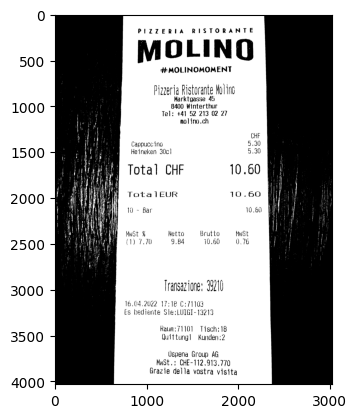

In [616]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Text Extraction

In [617]:
# Blacklist: -c tessedit_char_blacklist="!@%^&*_+=<>?/{}|\\~`£"
# OEM: --oem 3

image_text = pytesseract.image_to_string(img, lang='deu', config='--oem 3 --psm 4 -c tessedit_char_blacklist="!@%^&*_+=<>?/{}|\\~`£"')

image_text

"PIZZERIA RISTORANTE\n\nMOLINO\n\n#MOLINOMOMENT\n\nPizzeria Ristorante Moling\nMarktgasse 45\n8400 Winterthur\nTel: 441 52 213 02 27\nmolino.ch\n\nCHF\n\nCappuccino 5,30\n\nHeineken 30c1 5.30\n\nTotal CHF 10.60\n\nTotalEuRrR 10.60\n\n19 - Bar 10.50\nMWST Netto Brutto MWSt\n'i) 7.70 9,84 10.60 0.76\n\nIransazione: 3910\n\n16.14.2022 17:18 C:71103\nEs bediente Sie:LUIGI- 13213\n\nRaum:71101 Tisch; 18\nQuittung] Kunden:2\n\nUspena Group AG\nMuöt.: CHE-112.913.770\nGrazie della vostra visita\n\n"

In [618]:
print(image_text)

PIZZERIA RISTORANTE

MOLINO

#MOLINOMOMENT

Pizzeria Ristorante Moling
Marktgasse 45
8400 Winterthur
Tel: 441 52 213 02 27
molino.ch

CHF

Cappuccino 5,30

Heineken 30c1 5.30

Total CHF 10.60

TotalEuRrR 10.60

19 - Bar 10.50
MWST Netto Brutto MWSt
'i) 7.70 9,84 10.60 0.76

Iransazione: 3910

16.14.2022 17:18 C:71103
Es bediente Sie:LUIGI- 13213

Raum:71101 Tisch; 18
Quittung] Kunden:2

Uspena Group AG
Muöt.: CHE-112.913.770
Grazie della vostra visita




## Entity Extraction

In [620]:
items = [
    {
        'item': 'Cappuccino 5,30',
        'quantity': None,
        'name': 'Cappuccino',
        'price': '5,30'
    },
    {
        'item': 'Heineken 30c1 5.30',
        'quantity': None,
        'name': 'Heineken 30c1',
        'price': '5.30'
    },
]



entities = []
for entity in items:
    # item
    item = entity['item']
    item_starting_index = image_text.index(item)
    item_end_index = item_starting_index + len(item)
    entities.append([item_starting_index, item_end_index, "RECEIPT_ITEM"])
    print(f'\nItem: "{item}" starts at: {item_starting_index}, ends at: {item_end_index}')
    
    # quantity
    if entity['quantity'] is not None:
        item_quantity = entity['quantity']
        starting_index = item_starting_index + item.index(item_quantity)
        end_index = starting_index + len(item_quantity)
        entities.append([starting_index, end_index, "RECEIPT_ITEM_QUANTITY"])
        print(f'\tQuantity: "{item_quantity}" starts at: {starting_index}, ends at: {end_index}')
        
    # name
    if entity['name'] is not None:
        item_name = entity['name']
        starting_index = item_starting_index + item.index(item_name)
        end_index = starting_index + len(item_name)
        entities.append([starting_index, end_index, "RECEIPT_ITEM_NAME"])
        print(f'\tName: "{item_name}" starts at: {starting_index}, ends at: {end_index}')
        
    # price
    if entity['price'] is not None:
        item_price = entity['price']
        starting_indices = [item_starting_index + i.start() for i in re.finditer(item_price, item)]
        end_indices = [start + len(item_price) for start in starting_indices]
        
        if len(starting_indices) != 1:
            print('WARNING! Found Multiple Prices! Delete the wrong ones out of the array!')
        for start, end in zip(starting_indices, end_indices):
            entities.append([start, end, "RECEIPT_ITEM_PRICE"])
            print(f'\tPrice: "{item_price}" starts at: {start}, ends at: {end}')


Item: "Cappuccino 5,30" starts at: 139, ends at: 154
	Name: "Cappuccino" starts at: 139, ends at: 149
	Price: "5,30" starts at: 150, ends at: 154

Item: "Heineken 30c1 5.30" starts at: 156, ends at: 174
	Name: "Heineken 30c1" starts at: 156, ends at: 169
	Price: "5.30" starts at: 170, ends at: 174


Check the output of the entity extraction and make sure everything is correct. The indexes could be wrong because of the string.index() only returns the first match.

In [621]:
entities

[[139, 154, 'RECEIPT_ITEM'],
 [139, 149, 'RECEIPT_ITEM_NAME'],
 [150, 154, 'RECEIPT_ITEM_PRICE'],
 [156, 174, 'RECEIPT_ITEM'],
 [156, 169, 'RECEIPT_ITEM_NAME'],
 [170, 174, 'RECEIPT_ITEM_PRICE']]

### !!(OPTIONAL)!! Fix if neccessary

To fix the indexes copy the part from above and overwrite the entites array with the correct indicies

In [573]:
## WARNING: only when necessary

entities = [[213, 234, 'RECEIPT_ITEM'],
 [213, 214, 'RECEIPT_ITEM_QUANTITY'],
 [215, 221, 'RECEIPT_ITEM_NAME'],
 [229, 234, 'RECEIPT_ITEM_PRICE'],
 [235, 267, 'RECEIPT_ITEM'],
 [235, 236, 'RECEIPT_ITEM_QUANTITY'],
 [237, 257, 'RECEIPT_ITEM_NAME'],
 [263, 267, 'RECEIPT_ITEM_PRICE'],
 [268, 292, 'RECEIPT_ITEM'],
 [268, 269, 'RECEIPT_ITEM_QUANTITY'],
 [270, 279, 'RECEIPT_ITEM_NAME'],
 [287, 292, 'RECEIPT_ITEM_PRICE'],
 [293, 319, 'RECEIPT_ITEM'],
 [293, 294, 'RECEIPT_ITEM_QUANTITY'],
 [295, 309, 'RECEIPT_ITEM_NAME'],
 [315, 319, 'RECEIPT_ITEM_PRICE'],
 [320, 350, 'RECEIPT_ITEM'],
 [320, 321, 'RECEIPT_ITEM_QUANTITY'],
 [322, 337, 'RECEIPT_ITEM_NAME'],
 [345, 350, 'RECEIPT_ITEM_PRICE'],
 [351, 382, 'RECEIPT_ITEM'],
 [351, 352, 'RECEIPT_ITEM_QUANTITY'],
 [353, 370, 'RECEIPT_ITEM_NAME'],
 [378, 382, 'RECEIPT_ITEM_PRICE']]

## Save Image Reference, Extracted Text & Entities to Dataset

Load the already existing training data. Use a separate File for different types of receipts or new labeling entities.

In [622]:
try:
    # TODO: use different file when starting new labling session and update bottom write execution
    file = open('../data/datasets/ner-swiss-receipts.json', 'r')
except FileNotFoundError:
    print('file not found')
    data = []
else:
    with file:
        data = json.load(file)

In [623]:
new_data_entry = {
    "image_name": image_name,
    "text": image_text,
    "entities": entities,
}

new_data_entry

{'image_name': 'swiss_receipt_51.jpeg',
 'text': "PIZZERIA RISTORANTE\n\nMOLINO\n\n#MOLINOMOMENT\n\nPizzeria Ristorante Moling\nMarktgasse 45\n8400 Winterthur\nTel: 441 52 213 02 27\nmolino.ch\n\nCHF\n\nCappuccino 5,30\n\nHeineken 30c1 5.30\n\nTotal CHF 10.60\n\nTotalEuRrR 10.60\n\n19 - Bar 10.50\nMWST Netto Brutto MWSt\n'i) 7.70 9,84 10.60 0.76\n\nIransazione: 3910\n\n16.14.2022 17:18 C:71103\nEs bediente Sie:LUIGI- 13213\n\nRaum:71101 Tisch; 18\nQuittung] Kunden:2\n\nUspena Group AG\nMuöt.: CHE-112.913.770\nGrazie della vostra visita\n\n",
 'entities': [[139, 154, 'RECEIPT_ITEM'],
  [139, 149, 'RECEIPT_ITEM_NAME'],
  [150, 154, 'RECEIPT_ITEM_PRICE'],
  [156, 174, 'RECEIPT_ITEM'],
  [156, 169, 'RECEIPT_ITEM_NAME'],
  [170, 174, 'RECEIPT_ITEM_PRICE']]}

In [624]:
data.append(new_data_entry)

# convert into JSON:
json_data = json.dumps(data)

# TODO: use different file when starting new labling session and update bottom write execution
with open("../data/datasets/ner-swiss-receipts.json", "w+") as outfile:
    outfile.write(json_data)
    
print('added training data')

added training data
